In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from glob import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
print(f'{torch.cuda.is_available()=}')

CLASSES = [
    "background",
    "car",
    "wheel",
    "lights",
    "window",
]

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform

        self.filenames = sorted([
            fname for fname in os.listdir(images_dir)
            if os.path.isfile(os.path.join(images_dir, fname))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


torch.cuda.is_available()=True


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

CLASS_COLORS = [
    (0, 0, 0),  
    (255, 0, 0),
    (0, 255, 0),   
    (0, 0, 255),
    (255, 255, 0),
]
    

def decode_mask(mask):
    mask = mask.numpy() if isinstance(mask, torch.Tensor) else mask
    if mask.shape[0] == 1:
        mask = mask[0]
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_idx, color in enumerate(CLASS_COLORS):
        color_mask[mask == class_idx] = color
    return color_mask

def show_image_and_mask(image, mask, figsize=(10, 5)):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    color_mask = decode_mask(mask)
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(color_mask)
    plt.title("Mask")
    legend_patches = [
        mpatches.Patch(color=np.array(color)/255.0, label=cls)
        for cls, color in zip(CLASSES, CLASS_COLORS)
    ]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor()
])

dataset = SegmentationDataset("car-segmentation/images/", "car-segmentation/masks/", transform=image_transform, target_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

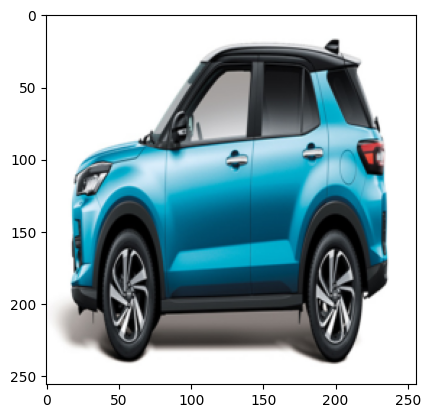

In [32]:
Image.Open()

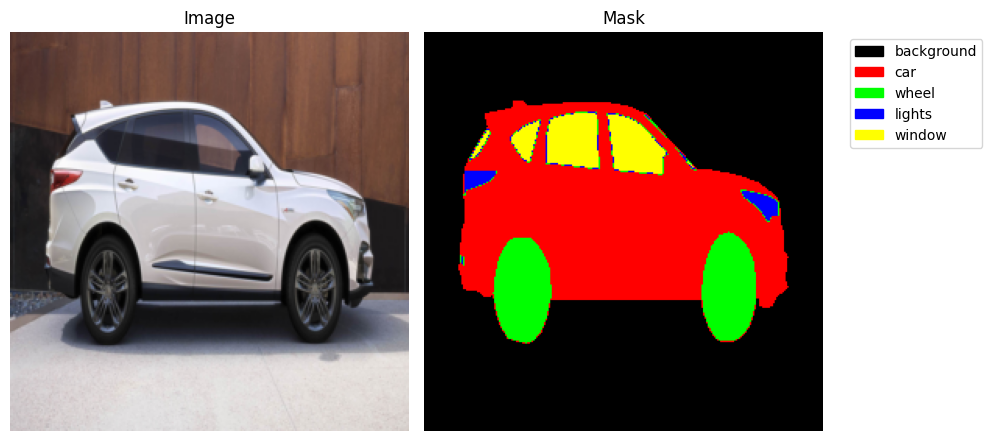

In [36]:
show_image_and_mask(*dataset[12])

In [27]:
np.array(Image.open(glob('car-segmentation/masks/*')[0])).max()

4

In [15]:
glob('car-segmentation/masks/*')[0]

'car-segmentation/masks\\003.png'

# SAM

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


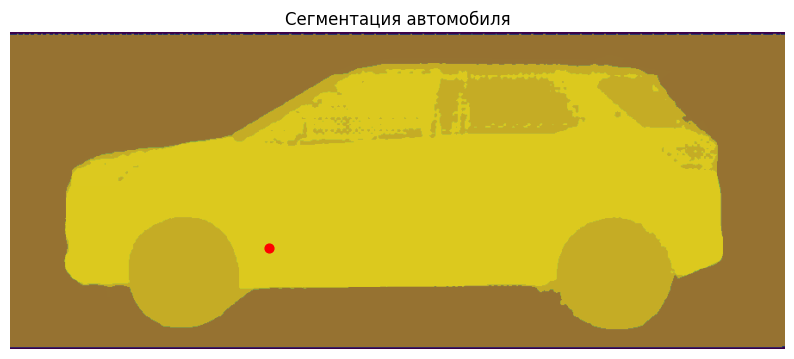

In [7]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

image_path = glob('car-segmentation/masks/*')[0]
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

input_point = np.array([[300, 250]]) 
input_label = np.array([1])

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
for mask in masks:
    plt.imshow(mask, alpha=0.5)
plt.scatter(input_point[:, 0], input_point[:, 1], c='red', s=40)
plt.axis('off')
plt.title("Сегментация автомобиля")
plt.show()


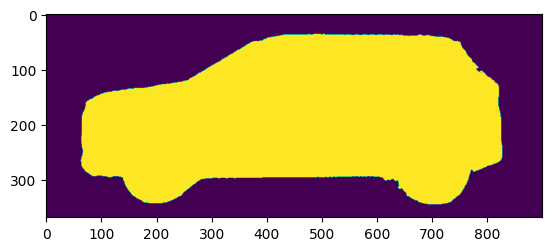

In [103]:
plt.imshow(masks[np.argmax(scores)].astype(int))


0: 320x640 1 car, 25.3ms
Speed: 2.1ms preprocess, 25.3ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


C:\Users\User\AppData\Local\Temp\ipykernel_22132\3037159348.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


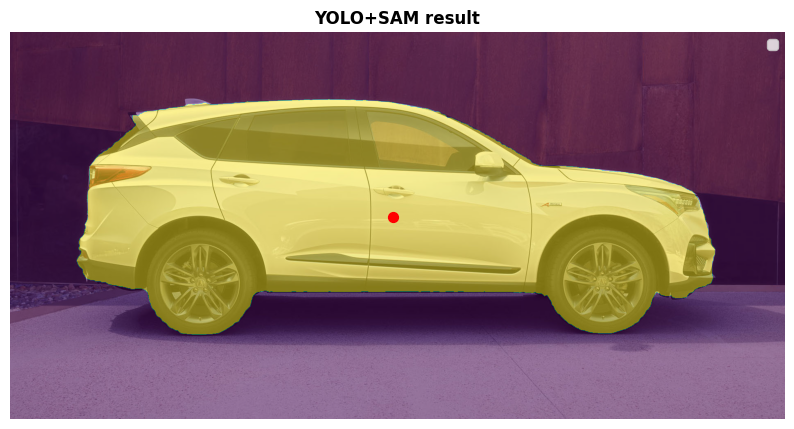

In [42]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO

image_path = glob('car-segmentation/images/*')[12]
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# YOLO
yolo_model = YOLO('yolov8n.pt') 
results = yolo_model(image_rgb)
max_area = 0
for box in results[0].boxes:
    class_id = int(box.cls.item())
    if class_id == 2:  # car class
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        if area > max_area:
            max_area = area
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            input_point = np.array([[cx, cy]])
            biggest_box = (x1, y1, x2, y2) 

if input_point is None:
    raise Exception("No car")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

input_label = np.array([1])  # 1 = foreground
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True
)

areas = [np.sum(mask) for mask in masks]
best_mask = masks[np.argmax(areas)]

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.imshow(best_mask, alpha=0.5, label='SAM Mask')
plt.scatter(input_point[:, 0], input_point[:, 1], c='red', s=50)
plt.legend()
plt.title('YOLO+SAM result', weight='bold')
plt.axis('off')
plt.show()


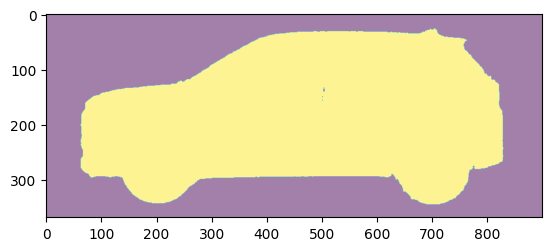

In [27]:
plt.imshow(masks[2], alpha=0.5)